This notebook is associated to the publication titled "Activated CD8+ T cells and macrophages form spatially organized niches that define chemotherapy response in breast cancer" by Sarkar et al. It loads some example data, which are binary masks for different markers of interest obtained using Visiopharm on the Imaging Mass Cytometry (IMC) dataset at [this link](https://www.ebi.ac.uk/biostudies/bioimages/studies/S-BIAD2027). It then computes the minimum distance between cells positive to two different markers of interest.

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io, measure
from skimage.transform import resize
from skimage.measure import label, regionprops
import pandas as pd
import seaborn as sns
from scipy import spatial
from scipy.spatial import distance

### Define utility functions

In [2]:
# function to quantify positivity to a relevant marker for each object in a labelled image
# takes as input the labelled image and the binary mask for the relevant marker
# gives as ouput a dataframe where each row represent one object and a binary score for the marker of interest (pos/neg)

def quantify_positive(labels, binary_mask):
    
    # use regionprops to quantify binary mask intensity for each object
    props_df = measure.regionprops_table(labels, binary_mask.astype(int), properties=['label', 'image_intensity'])
    props_df = pd.DataFrame(props_df)
    
    # mark as positive if at least half the pixels in the current labelled obj are positive in the mask for relevant marker
    for i, row in props_df.iterrows():
        temp = row['image_intensity']
        temp_median = np.median(temp)
        if temp_median >= 0.5: 
            props_df.at[i,'marker_positive'] = 1
        else:
            props_df.at[i,'marker_positive'] = 0
            
    # rename columns
    props_df = props_df[['label', 'marker_positive']]
    
    return props_df

### Import example data (binary masks)

In [3]:
# define input folder
input_folder = "./data/"

# load masks
cytoplasm = io.imread(input_folder+'cytoplasm.tif')
CD8 = io.imread(input_folder+'cd8.tif')
CD68 = io.imread(input_folder+'cd68.tif')
ROIs = io.imread(input_folder+'ROIs.tif')

### Quantify cell positivity for each marker

In [4]:
# binarise
cytoplasm_binary = cytoplasm > 0
CD8_binary = CD8 > 0
CD68_binary = CD68 > 0

# create label image for cells (cytoplasm)
cytoplasm_labels = measure.label(cytoplasm_binary)

# find cell centroid for visualisation
props_cells = measure.regionprops_table(cytoplasm_labels, properties=['label', 'centroid'])
props_cells = pd.DataFrame(props_cells)
props_cells.columns = ['cell_label', 'centroid0', 'centroid1']

# quantify: CD8 positive (uses utility function)
props_cd8 = quantify_positive(cytoplasm_labels, CD8_binary)
props_cd8.columns = ['cell_label', 'CD8_positive_cell']

# quantify: CD68 positive (uses utility function)
props_cd68 = quantify_positive(cytoplasm_labels, CD68_binary)
props_cd68.columns = ['cell_label', 'CD68_positive_cell']

# merge
props_cells = pd.merge(props_cells, props_cd8, left_on = ['cell_label'], right_on = ['cell_label'], how = 'outer')
props_cells = pd.merge(props_cells, props_cd68, left_on = ['cell_label'], right_on = ['cell_label'], how = 'outer')

In [5]:
props_cells.head()

,cell_label,centroid0,centroid1,CD8_positive_cell,CD68_positive_cell
0,1,2.494382,570.370787,0.0,0.0
1,2,2.957895,591.978947,0.0,0.0
2,3,2.415094,603.754717,0.0,0.0
3,4,4.616667,611.566667,0.0,0.0
4,5,2.451613,620.548387,0.0,0.0


### Visualise distribution

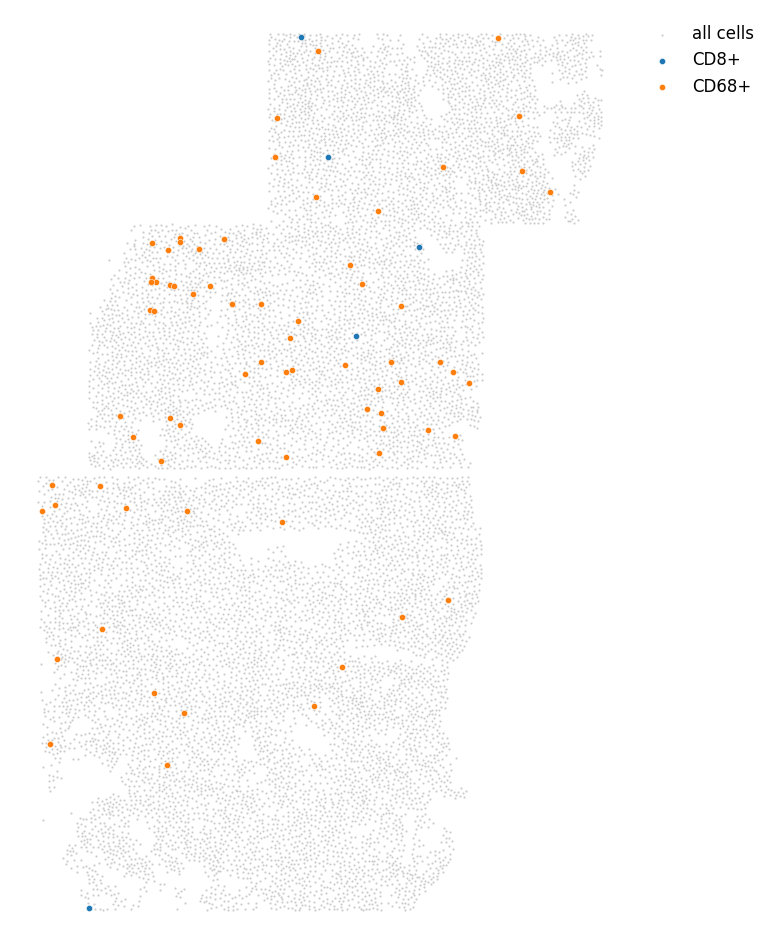

In [6]:
plt.figure(figsize=(8,12))

sns.scatterplot(data=props_cells, x='centroid1', y='centroid0', marker='.', s = 10, color='k', alpha = 0.2)
sns.scatterplot(data=props_cells.loc[props_cells['CD8_positive_cell'] == 1], x='centroid1', y='centroid0', marker='o', s = 20, color='C0')
sns.scatterplot(data=props_cells.loc[props_cells['CD68_positive_cell'] == 1], x='centroid1', y='centroid0', marker='o', s = 20, color='C1')

leg = plt.legend(labels=['all cells', 'CD8+', 'CD68+'], frameon=False, bbox_to_anchor=(1, 1), fontsize=12)

plt.gca().invert_yaxis()
plt.axis('equal')
plt.axis('off')
plt.show()

### Calculate distance between CD8+ and CD68+ cells

In [7]:
# subset props_cells dataframe to find CD8+ and CD68+ cells
df_CD8 = props_cells.loc[props_cells['CD8_positive_cell'] == 1]
df_CD68 = props_cells.loc[props_cells['CD68_positive_cell'] == 1]

In [8]:
# create labelled image from binary mask highlighting ROIs
label_img = label(ROIs)

In [9]:
# initialise output and ROI count
df_CD68_out = pd.DataFrame()
region_count = 0

# analyse one ROI at a time
for region in regionprops(label_img):

    # subset df_CD8 to current ROI only
    df_CD8_temp = df_CD8.loc[(df_CD8["centroid0"]>region.bbox[0]) & 
        (df_CD8["centroid0"]<region.bbox[2]) & 
        (df_CD8["centroid1"]>region.bbox[1]) & 
        (df_CD8["centroid1"]<region.bbox[3])]
    
    # subset df_CD68 to current ROI only
    df_CD68_temp = df_CD68.loc[(df_CD68["centroid0"]>region.bbox[0]) & 
        (df_CD68["centroid0"]<region.bbox[2]) & 
        (df_CD68["centroid1"]>region.bbox[1]) & 
        (df_CD68["centroid1"]<region.bbox[3])]

    # calculate distance matrix: each row is a CD68+ cell, each column is a CD8+ cell 
    dist = distance.cdist(df_CD68_temp.loc[:,['centroid0','centroid1']], df_CD8_temp.loc[:,['centroid0','centroid1']], metric='euclidean')
    dist = pd.DataFrame(dist)
    
    # remove cell if positive for both markers
    dist[(dist == 0)] = np.nan
    
    # find distance to closest CD8+ cell for each CD68+
    val_min = dist.min(axis=1)
    
    # save output
    df_CD68_temp['dist_closest_CD8'] = val_min.values
    df_CD68_temp['ROI'] = region_count
    df_CD68_out = pd.concat([df_CD68_out, df_CD68_temp])
    
    # update current ROI count
    region_count = region_count+1

df_CD68_out.head()

,cell_label,centroid0,centroid1,CD8_positive_cell,CD68_positive_cell,dist_closest_CD8,ROI
80,81,11.625000,1127.153846,0.0,1.0,479.365113,0
259,260,43.604167,689.583333,0.0,1.0,54.032259,0
1188,1189,202.834437,1178.933775,0.0,1.0,401.518173,0
1217,1218,205.795181,587.710843,0.0,1.0,157.986641,0
1815,1816,301.576271,584.474576,0.0,1.0,129.316181,0


In [10]:
# group by ROI
df_CD68_group = df_CD68_out.groupby(['ROI'])['dist_closest_CD8'].median().to_frame()
df_CD68_group = df_CD68_group.reset_index()
df_CD68_group.head()

,ROI,dist_closest_CD8
0,0,386.561737
